# Import 

In [5]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from matplotlib import pyplot as plt
from gemseo import sample_disciplines
from gemseo import to_pickle
from gemseo.disciplines.surrogate import SurrogateDiscipline
from gemseo import to_pickle
import pandas as pd
from gemseo.algos.design_space import DesignSpace

configure_logger()

<RootLogger root (INFO)>

# Instanciate disciplines

In [4]:
# On veut résoudre le problème 1 avec UC1 et UC2
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

# Create design space

In [6]:
design_space = DesignSpace()
design_space.add_variable('slst', lower_bound=100000.0, upper_bound=200000.0, value=150000.0)
design_space.add_variable('n_pax', lower_bound=120, upper_bound=180, value=150)
design_space.add_variable('area', lower_bound=100, upper_bound=200, value=180)
design_space.add_variable('ar', lower_bound=5, upper_bound=20, value=9)
design_space.add_variable('aef', lower_bound=0.99, upper_bound=1.03, value=1.0)
design_space.add_variable('cef', lower_bound=0.99, upper_bound=1.03, value=1.0)
design_space.add_variable('sef', lower_bound=0.99, upper_bound=1.03, value=1.0)

# Split train/test dataset

In [7]:
training_dataset = sample_disciplines(disciplines, design_space, ["mtom","tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_OPT_LHS", n_samples=28)
test_dataset = sample_disciplines(disciplines, design_space, ["mtom","tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_MONTE_CARLO", n_samples=28)

    INFO - 19:30:55: *** Start Sampling execution ***
    INFO - 19:30:55: Sampling
    INFO - 19:30:55:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 19:30:55:    MDO formulation: MDF
    INFO - 19:30:55: Running the algorithm OT_OPT_LHS:
    INFO - 19:30:55:    100%|██████████| 28/28 [00:00<00:00, 242.71 it/sec]
    INFO - 19:30:55: *** End Sampling execution (time: 0:00:00.126078) ***
    INFO - 19:30:55: *** Start Sampling execution ***
    INFO - 19:30:55: Sampling
    INFO - 19:30:55:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 19:30:55:    MDO formulation: MDF
    INFO - 19:30:55: Running the algorithm OT_MONTE_CARLO:
    INFO - 19:30:55:    100%|██████████| 28/28 [00:00<00:00, 259.87 it/sec]
    INFO - 19:30:55: *** End Sampling execution (time: 0:00:00.110670) ***


# Try different surrogate

 Testing surrogate: RBF_gaussian
 Testing surrogate: RBF_gaussian_mg
 Testing surrogate: Polynomial_deg2
 Testing surrogate: Polynomial_deg2

Résultats comparatifs :
                     fm  length    mtom    span    tofl    vapp      vz
Model                                                                  
RBF_gaussian     0.5798  0.7119  0.7591  0.6268  0.6382  0.6970  0.6565
RBF_gaussian_mg  0.9601  0.9911  0.9778  0.9761  0.9514  0.9752  0.9730
Polynomial_deg2  0.9768  0.9920  0.9323  0.9530  0.9199  0.9347  0.9171
Polynomial_deg2  0.9129  0.9682  0.9037  0.8866  0.8440  0.8374  0.8960


<Figure size 1200x600 with 0 Axes>

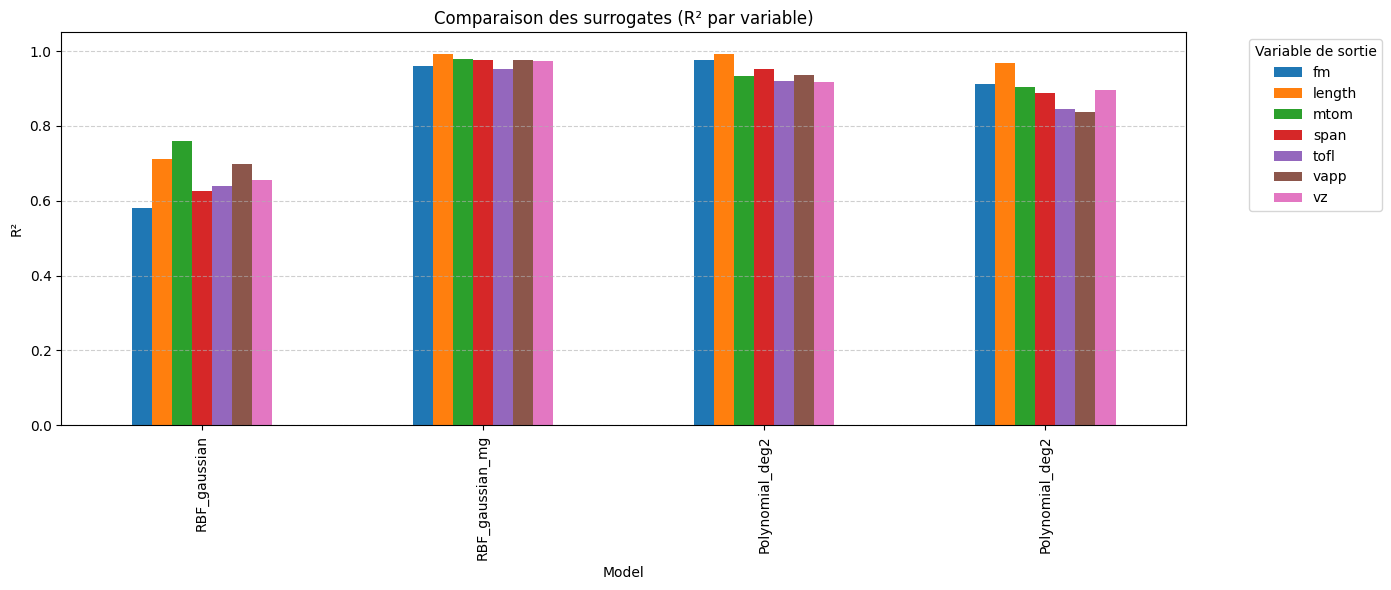

In [8]:
surrogate_configs = [
    {"name": "RBF_gaussian", "model": "RBFRegressor", "function": "gaussian"},
    {"name": "RBF_gaussian_mg", "model": "RBFRegressor", "function": "multiquadric"},
    {"name": "Polynomial_deg2", "model": "PolynomialRegressor", "degree": 2},
    {"name": "Polynomial_deg2", "model": "PolynomialRegressor", "degree": 3},
]

results = []

for config in surrogate_configs:
    name = config["name"]
    model_type = config["model"]
    kwargs = {k: v for k, v in config.items() if k not in ["name", "model"]}

    print(f" Testing surrogate: {name}")
    
    surrogate = SurrogateDiscipline(model_type, data=training_dataset, **kwargs)
    r2 = surrogate.get_error_measure("R2Measure")
    test_scores = r2.compute_test_measure(test_dataset, as_dict=True)
    
    flat_scores = {key: float(value) for key, value in test_scores.items()}
    flat_scores["Model"] = name
    results.append(flat_scores)

df_results = pd.DataFrame(results)
df_results = df_results.set_index("Model")
print("\nRésultats comparatifs :")
print(df_results.round(4)
)
plt.figure(figsize=(12, 6))
df_results.plot(kind="bar", figsize=(14, 6))
plt.title("Comparaison des surrogates (R² par variable)")
plt.ylabel("R²")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Variable de sortie", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save best surrogate

In [9]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor", data = training_dataset, function="multiquadric")

In [11]:
r2.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.91287283]),
 'length': array([0.96820496]),
 'mtom': array([0.90369761]),
 'span': array([0.88663085]),
 'tofl': array([0.84397488]),
 'vapp': array([0.83742036]),
 'vz': array([0.89604237])}

In [12]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.11535791]),
 'length': array([0.32139825]),
 'mtom': array([530.4872273]),
 'span': array([1.32083709]),
 'tofl': array([77.43164904]),
 'vapp': array([0.98387464]),
 'vz': array([0.72047582])}

In [13]:
to_pickle(surrogate_discipline, "my_surrogate_3.pkl")